<Axes: xlabel='tmax', ylabel='tmax_tomorrow'>

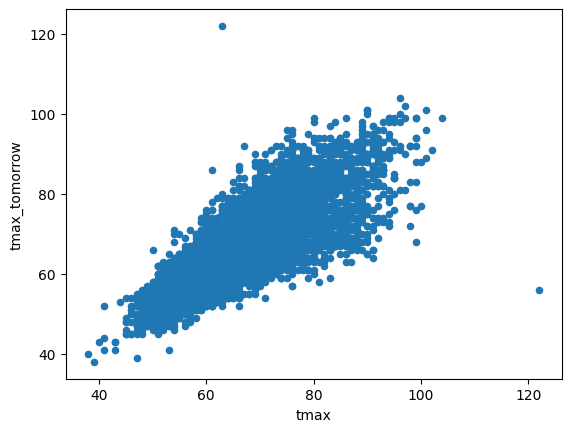

In [ ]:
import pandas as pd

# read the CSV file "clean_weather.csv" into a DataFrame.
# set the first column (usually the date or unnamed index) as the DataFrame index.
data = pd.read_csv("clean_weather.csv", index_col=0)

# forward-fill missing values (NaNs) in the DataFrame using the last known non-missing value.
# this is useful in time series data where missing values can be inferred from prior entries.
data = data.ffill()

# create a scatter plot to visualize the relationship between today's maximum temperature (tmax)
# and tomorrow's maximum temperature (tmax_tomorrow). This helps assess if a linear trend exists.
data.plot.scatter("tmax", "tmax_tomorrow")


In [ ]:
# see correlation coefficient (how linear)
data.corr()

# 0.81 coefficient (strong, but not perfect linear relation)

,tmax,tmin,rain,tmax_tomorrow
tmax,1.000000,0.615604,-0.219941,0.818561
tmin,0.615604,1.000000,-0.019546,0.585572
rain,-0.219941,-0.019546,1.000000,-0.211799
tmax_tomorrow,0.818561,0.585572,-0.211799,1.000000


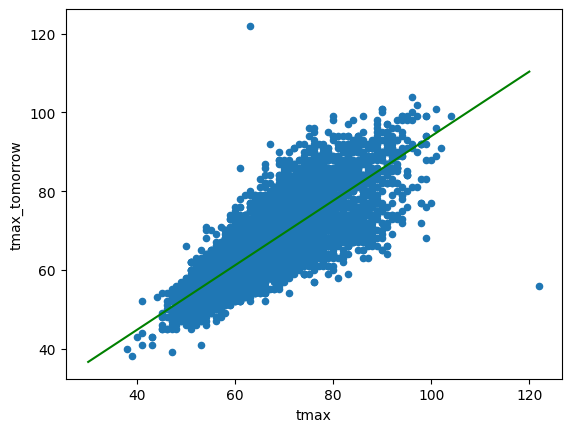

In [ ]:
import matplotlib.pyplot as plt

# create a scatter plot using the DataFrame 'data'
# plot today's max temperature ("tmax") on the x-axis
# and tomorrow's max temperature ("tmax_tomorrow") on the y-axis
data.plot.scatter("tmax", "tmax_tomorrow")

# define a simple linear prediction function using a lambda
# it predicts tomorrow's temperature based on today's temperature (x)
# using a slope (w1) of 0.82 and a y-intercept (b) of 11.99
prediction = lambda x, w1=.82, b=11.99: x * w1 + b

# plot the prediction line in green from x = 30 to x = 120
# this shows the linear model over the scatter plot
plt.plot([30, 120], [prediction(30), prediction(120)], 'green')


In [ ]:
import numpy as np

# define a function to calculate mean squared error
def mse(actual, predicted):
    # subtract the predicted values from the actual values, square the differences,
    # then take the mean of all squared differences
    return np.mean((actual - predicted) ** 2)

# calculate and print the mean squared error between the true maximum temperatures 
# for tomorrow and the predicted values based on today's temperatures
print(mse(data["tmax_tomorrow"], prediction(data["tmax"])))

22.897335324598416


/var/folders/03/bxkf6j8127v3r9p54h600lzh0000gn/T/ipykernel_83261/3141704153.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_ratio = ratios.groupby(tmax_bins).mean()
/var/folders/03/bxkf6j8127v3r9p54h600lzh0000gn/T/ipykernel_83261/3141704153.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_tmax = data["tmax"].groupby(tmax_bins).mean()


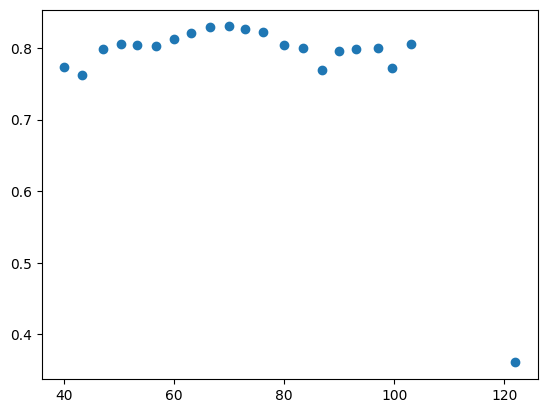

In [ ]:
# divide the "tmax" column into 25 equally sized temperature intervals (bins)
tmax_bins = pd.cut(data["tmax"], 25)

# compute a ratio for each row: how much tomorrow's max temperature deviates from 11.99,
# scaled by today's temperature
ratios = (data["tmax_tomorrow"] - 11.99) / data["tmax"]

# for each bin of "tmax", calculate the average of the corresponding ratios
binned_ratio = ratios.groupby(tmax_bins).mean()

# for each bin, also calculate the average value of "tmax" itself
binned_tmax = data["tmax"].groupby(tmax_bins).mean()

# plot the average "tmax" (x-axis) against the average ratio (y-axis) per bin
plt.scatter(binned_tmax, binned_ratio)

# tomorrow’s temperature tends to be lower than today’s temperature plus a fixed offset (around 12)
# but around 120, the temp is like 30% less plus 12
# example of a nonlienar regressio that linear regression cant model

neural networks do three key things

- add a non-linear transformation on top of linear transformation
- ultple layers, which can capture interactions between features
- multiple hidden units, which can have slightly different linear and nonlinear transformations

ACTIVATION FUNCTION
- most common is ReLU (set everything below 0 to 0)
- EXAMPLE:
$y = wx + b$
into
$y = relu(wx+b)$

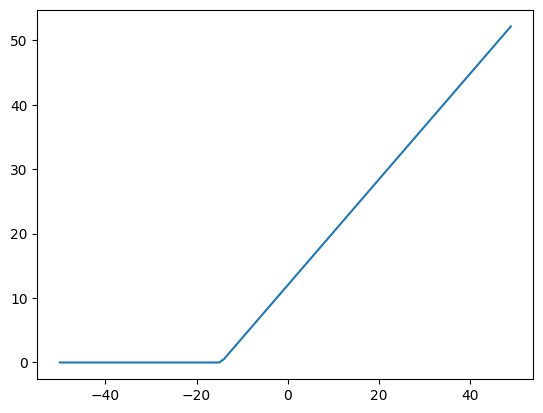

In [ ]:
# example usage of the ReLU activation function
temps = np.arange(-50,50)
plt.plot(temps, np.maximum(0, prediction(temps)))

MULTIPLE LAYERS
- two layer neural network
- instead of just $\hat{y} = relu(wx+b)$, we have $\hat{y} = w_{2}relu(w_{1}x + b_{1}) + b_{2}$

In [ ]:
# example usage of the ReLU activation function and multiple layers
temps = np.arange(-50,50)
layer1 = np.maximum(0, prediction(temps))
# supposed to be learned weights and biases
layer2 = prediction(layer1, 0.5, 10)

# plot
plt.plot(temps, layer2)
plt.ylim((0,40))

MULTIPLE NODES
- more nodes per layer help create nonlinear relationships

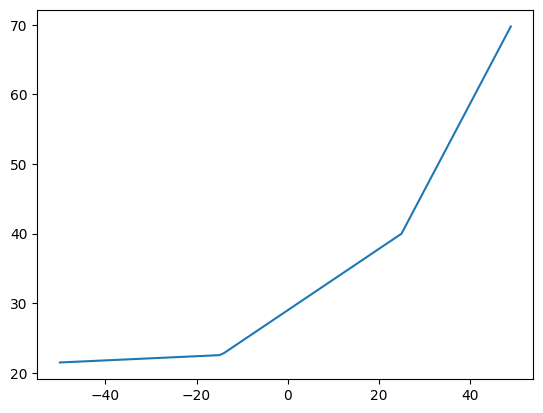

In [ ]:
# example usage of the ReLU, multiple layers, and multiple nodes
layer1_1 = np.maximum(0, prediction(temps))
# nn will calc weight and bias
layer1_2 = np.maximum(0, prediction(temps, .1, 10))
layer1_3 = np.maximum(0, prediction(temps, 2, -50))

# add layer 2 with new weights and bias
layer2 = layer1_1 * 0.5 + layer1_2 * 0.3 + layer1_3 * 0.4 + 20

plt.plot(temps, layer2)


how do we keep track of everything?
- using matricies!
- Inputs $$\begin{bmatrix} 80 \\ 90 \end{bmatrix}$$ 
- layer 1 weights $$\begin{bmatrix} 0.82 & 0.1 \end{bmatrix}$$
- layer 1 biases $$\begin{bmatrix} 11.99 & 10 \end{bmatrix}$$
- multiplying input and weights matricies, then adding biases gives the layer 1 output: $$\begin{bmatrix} 77.59 & 18 \\ 85.79 & 19 \end{bmatrix}$$
- more input = more rows to output

FORWARD PASS EXAMPLE (with made up weights and bias)
- used when we know weights and bias, so that a prediction can be made
- replace single points with matrices
- new equation is $layer_{1} = relu(XW_{1} + B_{1})$

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

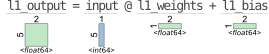

In [ ]:
# show the math behind it
import tsensor

input = np.array([[80], [90], [100], [-20], [-10]])

l1_weights = np.array([[.82, .1]])
l1_bias = np.array([[11.99,10]])
with tsensor.explain():
    l1_output = input @ l1_weights + l1_bias

In [33]:
l1_output

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [-4.41,  8.  ],
       [ 3.79,  9.  ]])

In [34]:
# relu activation
l1_activated = np.maximum(0, l1_output)
l1_activated

array([[77.59, 18.  ],
       [85.79, 19.  ],
       [93.99, 20.  ],
       [ 0.  ,  8.  ],
       [ 3.79,  9.  ]])

apply layer 2
- $\hat{y} = W_{2}relu(XW_{1} + B_{1}) + B_{2}$

findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

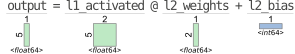

In [35]:
l2_weights = np.array([[0.5], [0.2]])
l2_bias = np.array([5])

with tsensor.explain():
    output = l1_activated @ l2_weights + l2_bias

In [37]:
# prepare for gradient descent example
tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])

def mse(actual, predicted):
    return (actual - predicted) ** 2

def mse_grad(actual, predicted):
    return predicted - actual


THE BACKWAWRDS PASS
- backpropagation to find weights and bias
    - use chain rule to calc how much each weight contributed to erroer
- gradient descent
    - mudhe weights in the direction that reduces loss
- calc the partial derivative of the loss with respect to each parmeter in the network


findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas' not found.
findfont: Font family 'Consolas'

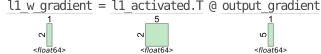

In [ ]:
from tsensor import explain as exp

# compute the gradient of the mean squared error loss with respect to the model output
output_gradient = mse_grad(tmax_tomorrow, output)

with exp():
    # compute the gradient of the loss with respect to the weights of layer 2 (l1_w)
    # by multiplying the transposed activations from layer 1 with the output gradient
    # tweak weights to reduce error
    l1_w_gradient = l1_activated.T @ output_gradient

$\frac{\partial L}{\partial W_{2}}$

$$\frac{\partial L}{\partial W_{2}} = \partial L\frac{\partial (XW_{2})}{\partial W_{2}}$$